In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from msapy import plottings as pl
import matplotlib.pyplot as plt
import scipy.io

import seaborn as sns
import utils as ut
import warnings
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from scipy.stats import pearsonr

from neurolib.models.hopf import HopfModel
import neurolib.utils.functions as func


In [5]:
SEED = 2023
pl.set_style(font_size=8)
CM = 1/2.54

DEEP_BLUE = '#006685'
BLUE = '#3FA5C4'
WHITE = '#FFFFFF'
HALF_BLACK = '#232324'
ORANGE = '#E84653'
RED= '#BF003F'

PURPLE = '#A6587C'
PURPLER = '#591154'
PURPLEST = '#260126'
NIGHT_BLUE = '#394D73'
YELLOW = '#E6B213'


from_white = [DEEP_BLUE, BLUE, WHITE, ORANGE, RED]
white_to_reds = [WHITE, ORANGE, RED]
white_to_blues = [WHITE, BLUE, DEEP_BLUE]

black_to_reds = [HALF_BLACK, ORANGE, RED]
black_to_blues = [HALF_BLACK, BLUE, DEEP_BLUE]

from_black = [DEEP_BLUE,BLUE,HALF_BLACK,ORANGE,RED]



diverge_from_white = sns.blend_palette(from_white,as_cmap=True)
diverge_from_black = sns.blend_palette(from_black,as_cmap=True)

white_red_mono = sns.blend_palette(white_to_reds,as_cmap=True)
white_blue_mono = sns.blend_palette(white_to_blues,as_cmap=True)

black_red_mono = sns.blend_palette(black_to_reds,as_cmap=True)
black_blue_mono = sns.blend_palette(black_to_blues,as_cmap=True)

purple_red = sns.blend_palette([PURPLEST, PURPLE, RED])

In [6]:
consensus_mat = scipy.io.loadmat('Consensus_Connectomes.mat',simplify_cells=True,squeeze_me=True,chars_as_strings=True)
consensus_mat['LauConsensus']['Readme']

array(['1 - weighted adj mat', '2 - fiber length mat', '3 - fc mat',
       '4 - coordinates', '5{1} - roi name', '5{2} - short name',
       '5{3} - rsn name', '5{4} - hemisphere'], dtype=object)

In [7]:
connectivity = ut.spectral_normalization(1,consensus_mat['LauConsensus']['Matrices'][2][0])
labels = consensus_mat['LauConsensus']['Matrices'][2][4][:,0]
human_fc = consensus_mat['LauConsensus']['Matrices'][2][2]
fiber_lengths = consensus_mat['LauConsensus']['Matrices'][2][1]

np.fill_diagonal(human_fc,0)

In [8]:
warnings.filterwarnings("ignore")
n_nodes = connectivity.shape[0]
rng = np.random.default_rng(seed=SEED)
delta = 0.01
tau = 0.02

G =0.74 #this is the optimal value based on the search below
duration = 1000
noise_strength = 0.05

noise = np.zeros((n_nodes,int(duration/delta)+1))
for i in range(int(duration/delta)+1):
    noise[:,i] = rng.normal(0,noise_strength,(n_nodes,))

In [112]:
from neurolib.models.wc import WCModel
model = WCModel(Cmat = connectivity, Dmat = np.zeros_like(connectivity))

model.params['signalV'] = 0
model.params['duration'] = 20 * 1000 
model.params['sigma_ou'] = noise_strength
model.params['exc_ext'] = 0.8


model.run(chunkwise=True)

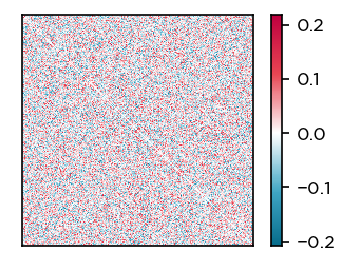

In [113]:
fc = np.corrcoef(model.exc)
np.fill_diagonal(fc,0)

plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

In [118]:
wc_parameter_space = list(ParameterGrid({'K_gl':np.linspace(0,40,21).round(2),
                                         'exc_ext':np.linspace(0,2,21).round(2)}))
for parameters in tqdm(wc_parameter_space,
                       total=len(wc_parameter_space),
                       desc='Optimizing hyperparams: '):
    model.params['K_gl'] = parameters['K_gl']
    model.params['exc_ext'] = parameters['exc_ext']

    model.run(chunkwise=True)

    fc = func.fc(model.exc)

    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = func.matrix_correlation(human_fc, fc)
        parameters.update({'correlation': r})
        
wc_optimum_params = max(wc_parameter_space, key=lambda x: x['correlation'])
wc_optimum_params

Optimizing hyperparams: 100%|██████████| 441/441 [2:58:50<00:00, 24.33s/it]  


{'K_gl': 20.0, 'exc_ext': 0.3, 'correlation': 0.20348238031695665}

In [115]:
model.params['K_gl'] = wc_optimum_params['K_gl']
model.run(chunkwise=True)

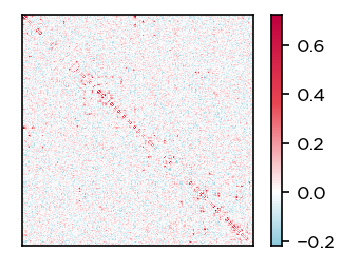

In [116]:
fc = np.corrcoef(model.exc)
np.fill_diagonal(fc,0)

plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

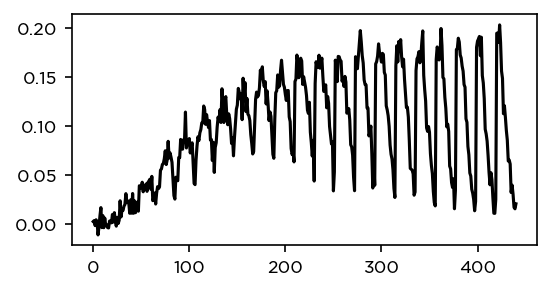

In [119]:
fit_results = []
for index,correlation in enumerate(wc_parameter_space):
    fit_results.append(wc_parameter_space[index]['correlation'])
    
plt.figure(figsize=(4,2),dpi=150)
plt.plot(fit_results,color='k')

PearsonRResult(statistic=0.2939729999398568, pvalue=0.0)

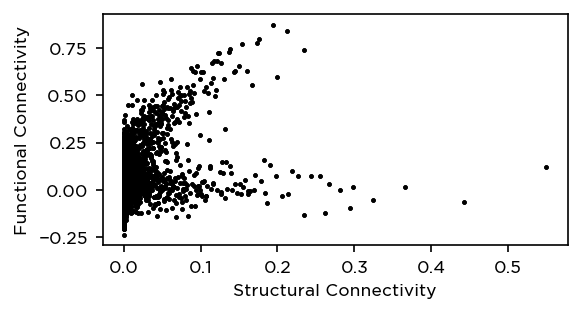

In [52]:
plt.figure(figsize=(4,2),dpi=150)
sns.scatterplot(x=connectivity.flatten(),y=fc.flatten(),color='k',s=5,linewidth=0);
plt.xlabel('Structural Connectivity')
plt.ylabel('Functional Connectivity')

pearsonr(connectivity.flatten(),fc.flatten())

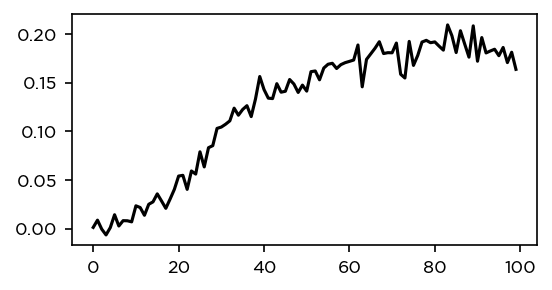

In [53]:
fit_results = []
for index,correlation in enumerate(wc_parameter_space):
    fit_results.append(wc_parameter_space[index]['correlation'])
    
plt.figure(figsize=(4,2),dpi=150)
plt.plot(fit_results,color='k')
#plt.xticks(np.arange(0,20,2),np.linspace(0.01,1.,20).round(2,)[::2]);

In [14]:
model = HopfModel(Cmat = connectivity, Dmat = fiber_lengths,)
model.params['sigma_ou'] = noise_strength
model.params['seed'] = SEED
model.params['duration'] = 50 * 1000


In [15]:
rng = np.random.default_rng(seed=SEED)
hopf_parameter_space = list(ParameterGrid({'K_gl':np.linspace(0.0,8,41).round(2),
                                           'a':np.linspace(-0.25,0.25,6).round(2)}))

for parameters in tqdm(hopf_parameter_space,
                       total=len(hopf_parameter_space),
                       desc='Optimizing hyperparams: '):

    model.params['K_gl'] = parameters['K_gl']
    model.params['a'] = parameters['a']
    model.run(chunkwise=True)

    fc = func.fc(model.x)

    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = func.matrix_correlation(human_fc, fc)
        parameters.update({'correlation': r})
        
hopf_optimum_params = max(hopf_parameter_space, key=lambda x: x['correlation'])
hopf_optimum_params

Optimizing hyperparams: 100%|██████████| 246/246 [3:54:07<00:00, 57.11s/it]  


{'K_gl': 8.0, 'a': 0.15, 'correlation': 0.3452398355629165}

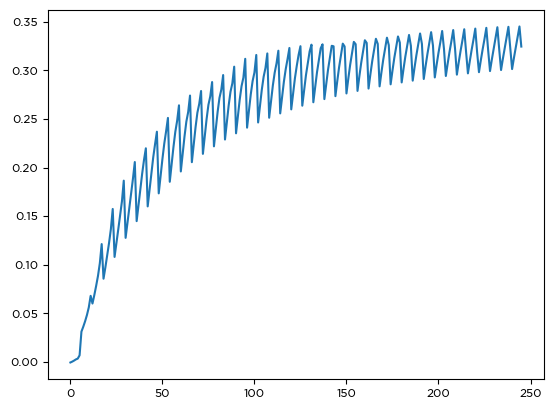

In [16]:
fit_results = []
for index,correlation in enumerate(hopf_parameter_space):
    fit_results.append(hopf_parameter_space[index]['correlation'])
plt.plot(fit_results);

In [17]:
model.params['K_gl'] = hopf_optimum_params['K_gl']
model.run(chunkwise=True)

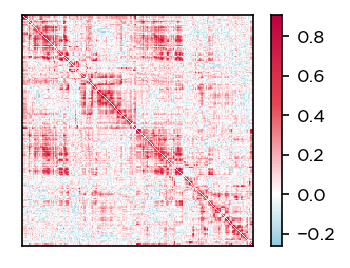

In [18]:
fc = np.corrcoef(model.x)
np.fill_diagonal(fc,0)

plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

In [19]:
model = HopfModel(Cmat = connectivity, Dmat = np.zeros_like(connectivity),)
model.params['sigma_ou'] = noise_strength
model.params['seed'] = SEED
model.params['duration'] = 50 * 1000
model.params['a'] = 0.15
 
rng = np.random.default_rng(seed=SEED)
hopf_parameter_space = list(ParameterGrid({'K_gl':np.linspace(0.0,8,41).round(2)}))

for parameters in tqdm(hopf_parameter_space,
                       total=len(hopf_parameter_space),
                       desc='Optimizing hyperparams: '):

    model.params['K_gl'] = parameters['K_gl']
    model.run(chunkwise=True)

    fc = func.fc(model.x)

    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = func.matrix_correlation(human_fc, fc)
        parameters.update({'correlation': r})
        
hopf_optimum_params = max(hopf_parameter_space, key=lambda x: x['correlation'])
hopf_optimum_params

Optimizing hyperparams: 100%|██████████| 41/41 [37:40<00:00, 55.14s/it]


{'K_gl': 3.4, 'correlation': 0.33639104865568753}

PearsonRResult(statistic=0.5290455646846771, pvalue=0.0)

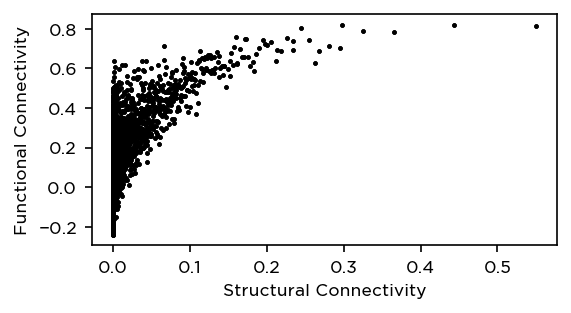

In [22]:
plt.figure(figsize=(4,2),dpi=150)
sns.scatterplot(x=connectivity.flatten(),y=fc.flatten(),color='k',s=5,linewidth=0);
plt.xlabel('Structural Connectivity')
plt.ylabel('Functional Connectivity')

pearsonr(connectivity.flatten(),fc.flatten())

In [9]:
sar_parameter_space = list(ParameterGrid({'omega':np.linspace(0.01,1.,20).round(2,)}))

In [10]:
for parameters in tqdm(sar_parameter_space,
                       total=len(sar_parameter_space),
                       desc='Optimizing hyperparams: '):
    fc = ut.sar_model(adjacency_matrix=connectivity, omega=parameters['omega'])
    np.fill_diagonal(fc,0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]
        parameters.update({'correlation': r})


Optimizing hyperparams: 100%|██████████| 20/20 [00:00<00:00, 66.61it/s]


In [11]:
sar_optimum_params = max(sar_parameter_space, key=lambda x: x['correlation'])
sar_optimum_params

{'omega': 0.27, 'correlation': 0.26289720480833156}

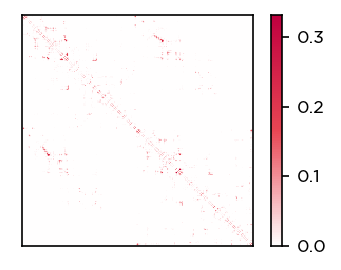

In [26]:
fc = ut.sar_model(adjacency_matrix=connectivity, omega=sar_optimum_params['omega'])
np.fill_diagonal(fc,0)

plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

PearsonRResult(statistic=0.9862885901806654, pvalue=0.0)

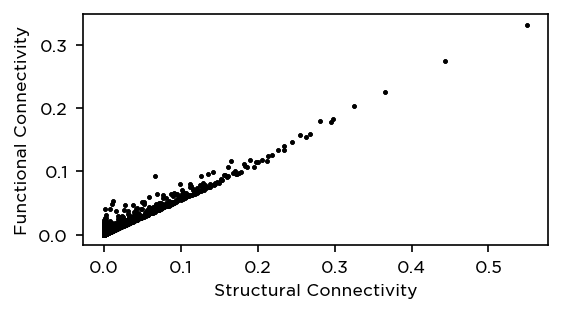

In [27]:
plt.figure(figsize=(4,2),dpi=150)
from scipy.stats import pearsonr
sns.scatterplot(x=connectivity.flatten(),y=fc.flatten(),color='k',s=5,linewidth=0);
plt.xlabel('Structural Connectivity')
plt.ylabel('Functional Connectivity')

pearsonr(connectivity.flatten(),fc.flatten())

In [28]:
simple_human_dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,coupling=G,dt=delta,timeconstant=tau,input_matrix=noise,duration=duration)

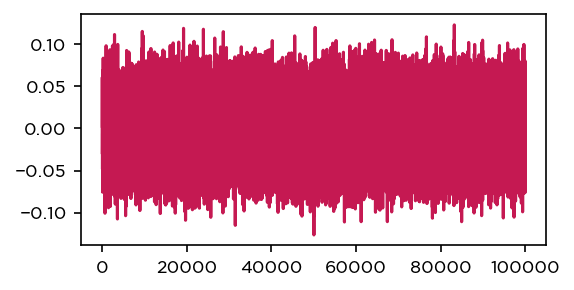

In [29]:
plt.figure(figsize=(4,2),dpi=150)
plt.plot(simple_human_dynamics[10],alpha=0.9,color=RED);
fc = np.corrcoef(simple_human_dynamics)
np.fill_diagonal(fc,0)
fc = np.nan_to_num(fc)

0.23416942950163158

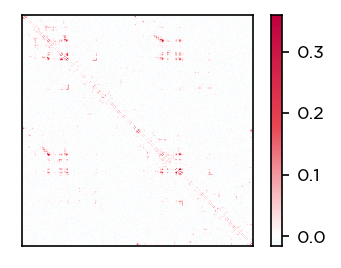

In [30]:
plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);
np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]

PearsonRResult(statistic=0.8188924074292802, pvalue=0.0)

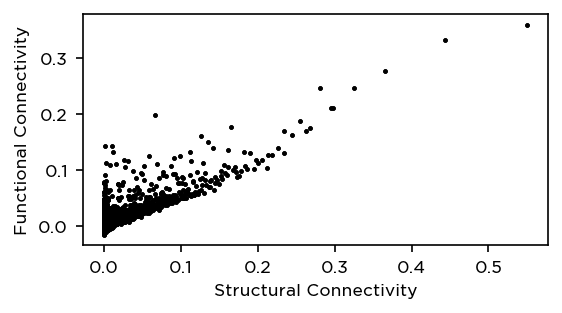

In [31]:
plt.figure(figsize=(4,2),dpi=150)
from scipy.stats import pearsonr
sns.scatterplot(x=connectivity.flatten(),y=fc.flatten(),color='k',s=5,linewidth=0);
plt.xlabel('Structural Connectivity')
plt.ylabel('Functional Connectivity')

pearsonr(connectivity.flatten(),fc.flatten())

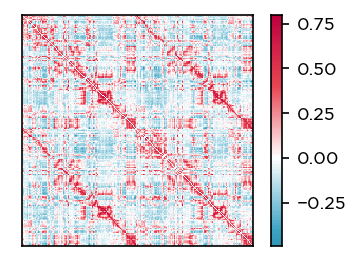

In [32]:
plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(human_fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

PearsonRResult(statistic=0.8188924074292802, pvalue=0.0)

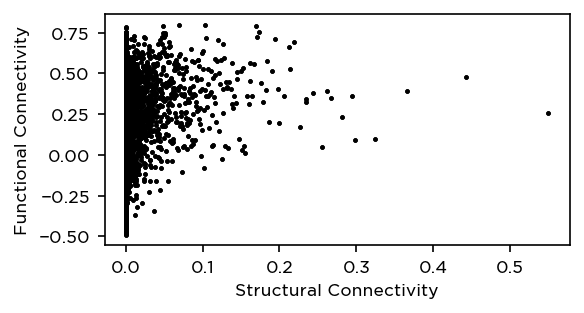

In [33]:
plt.figure(figsize=(4,2),dpi=150)
from scipy.stats import pearsonr
sns.scatterplot(x=connectivity.flatten(),y=human_fc.flatten(),color='k',s=5,linewidth=0);
plt.xlabel('Structural Connectivity')
plt.ylabel('Functional Connectivity')

pearsonr(connectivity.flatten(),fc.flatten())

In [34]:
parameter_space = list(ParameterGrid({'G':np.linspace(0.01,1.,20).round(2,)}))

In [35]:
for parameters in tqdm(parameter_space,
                       total=len(parameter_space),
                       desc='Optimizing hyperparams: '):
    dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,
                                    coupling=parameters['G'],
                                    dt=delta,
                                    timeconstant=tau,
                                    input_matrix=noise,
                                    duration=duration)
    
    fc = np.corrcoef(dynamics)
    np.fill_diagonal(fc,0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]
        parameters.update({'correlation': r})


Optimizing hyperparams: 100%|██████████| 20/20 [03:07<00:00,  9.39s/it]


In [36]:
optimum_params = max(parameter_space, key=lambda x: x['correlation'])
dynamics = ut.simulate_dynamical_system_parallel(adjacency_matrix=connectivity,
                                    coupling=optimum_params['G'],
                                    dt=delta,
                                    timeconstant=tau,
                                    input_matrix=noise,
                                    duration=duration)
fc = np.corrcoef(dynamics)
np.fill_diagonal(fc,0)
optimum_params

{'G': 0.74, 'correlation': 0.23416942950163158}

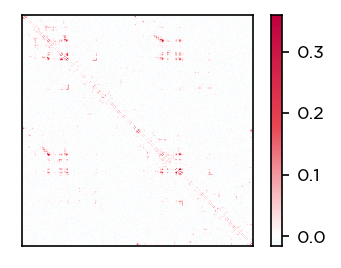

In [37]:
plt.figure(figsize=(3,2),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,linewidths=0.,yticklabels=False,xticklabels=False)
sns.despine(top=False, right=False, left=False, bottom=False);

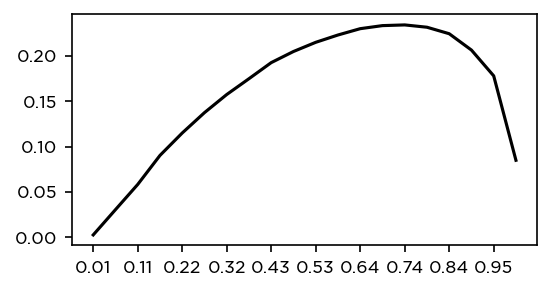

In [38]:
fit_results = []
for index,correlation in enumerate(parameter_space):
    fit_results.append(parameter_space[index]['correlation'])
    
plt.figure(figsize=(4,2),dpi=150)
plt.plot(fit_results,color='k')
plt.xticks(np.arange(0,20,2),np.linspace(0.01,1.,20).round(2,)[::2]);